In [1]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine, text, MetaData
from sqlalchemy.exc import IntegrityError
import numpy as np

In [2]:
engine = create_engine('postgresql:///piwheels')
conn = engine.connect()
meta = MetaData()
meta.bind = conn
meta.reflect(views=True)

In [3]:
start_date = '2021-10-01'
start_time = '2021-10-01 00:00:00'
end_date = '2021-12-31'
end_time = '2022-01-01 00:00:00'
one_year_ago = '2021-01-01'

In [4]:
pd.read_sql(f"""
    SELECT COUNT(*) AS downloads_in_period
    FROM downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,downloads_in_period
0,11942250


In [5]:
pd.read_sql(f"""
    SELECT COUNT(*) AS downloads_to_date
    FROM downloads
    WHERE accessed_at::date < '{end_date}'
""", conn)

,downloads_to_date
0,67608247


In [6]:
pd.read_sql(f"""
    SELECT COUNT(*) AS project_page_hits
    FROM project_page_hits
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,project_page_hits
0,886179


In [7]:
pd.read_sql(f"""
    SELECT COUNT(*) AS project_json_downloads
    FROM project_json_downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,project_json_downloads
0,294252


In [8]:
pd.read_sql(f"""
    SELECT COUNT(*) AS web_page_hits
    FROM web_page_hits
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,web_page_hits
0,420490


In [9]:
downloads_by_month = pd.read_sql(f"""
    SELECT date_trunc('month', accessed_at) m, COUNT(*) AS c
    FROM downloads
    WHERE accessed_at::date BETWEEN '{one_year_ago}' AND '{end_date}'
    GROUP BY m
    ORDER BY m
""", conn)

downloads_by_month

,m,c
0,2021-01-01,1960137
1,2021-02-01,3424032
2,2021-03-01,3878585
3,2021-04-01,2956219
4,2021-05-01,2752983
5,2021-06-01,2762739
6,2021-07-01,2325759
7,2021-08-01,2523731
8,2021-09-01,2198364
9,2021-10-01,4263286


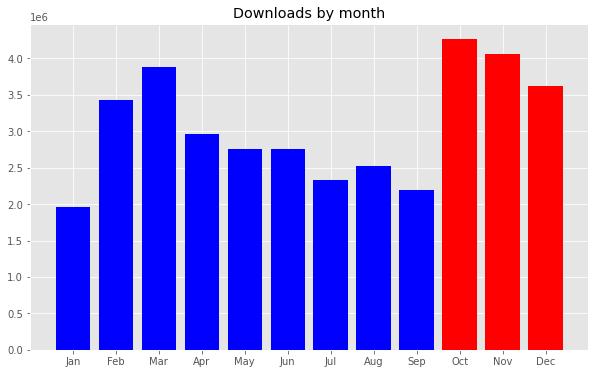

In [10]:
plt.rcParams["figure.figsize"] = (10, 6)

months = [m.month_name()[:3] for m in downloads_by_month['m']]
downloads = [c for c in downloads_by_month['c']]

colors = ['blue']*9 + ['red']*3
plt.bar(range(12), downloads, color=colors)
plt.title('Downloads by month')
plt.xticks(range(12), months)

plt.savefig('downloads-by-month.png')

plt.show()

In [11]:
downloads_by_day = pd.read_sql(f"""
    SELECT accessed_at::date AS d, COUNT(*) AS downloads
    FROM downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY d
    ORDER BY d
""", conn)

downloads_by_day

,d,downloads
0,2021-10-01,80803
1,2021-10-02,53710
2,2021-10-03,57521
3,2021-10-04,101745
4,2021-10-05,128958
...,...,...
87,2021-12-27,101178
88,2021-12-28,114851
89,2021-12-29,126240
90,2021-12-30,121266


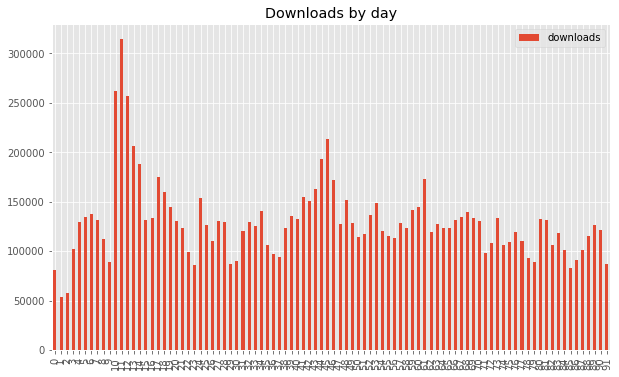

In [12]:
p = downloads_by_day.plot.bar(title='Downloads by day')
p.figure.savefig('downloads-by-day.png')

In [13]:
df = pd.read_sql(f"""
    SELECT COUNT(*) AS searches_in_period
    FROM searches
    WHERE accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
""", conn)

searches = df.values[0][0]
searches

58871182

In [14]:
pd.read_sql(f"""
    SELECT date_trunc('month', accessed_at) AS month, COUNT(*) AS searches
    FROM searches
    WHERE accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    GROUP BY month
    ORDER BY month
""", conn)

,month,searches
0,2021-10-01,17796527
1,2021-11-01,19277934
2,2021-12-01,21796721


In [15]:
searches_by_day = pd.read_sql(f"""
    SELECT accessed_at::date AS day, COUNT(*) AS searches
    FROM searches
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY day
    ORDER BY day
""", conn)

searches_by_day

,day,searches
0,2021-10-01,391134
1,2021-10-02,301977
2,2021-10-03,307558
3,2021-10-04,485043
4,2021-10-05,591023
...,...,...
87,2021-12-27,641929
88,2021-12-28,711941
89,2021-12-29,791003
90,2021-12-30,745988


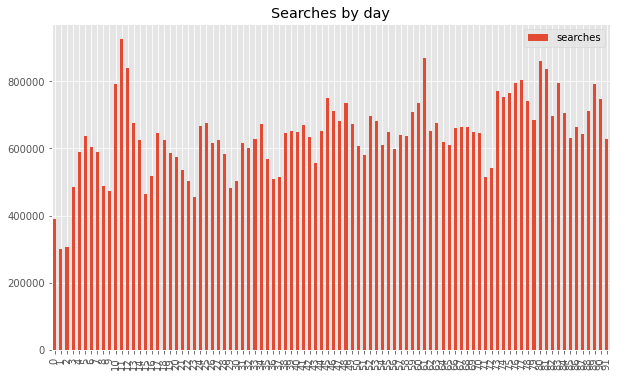

In [16]:
p = searches_by_day.plot.bar(title='Searches by day')
p.figure.savefig('searches-by-day.png')

In [17]:
pd.read_sql(f"""
    SELECT JUSTIFY_INTERVAL(SUM(
        CASE f.platform_tag
            WHEN 'linux_armv7l' THEN 1                           
            WHEN 'linux_armv6l' THEN 6                                                       
            ELSE 0           
        END *
        CASE                        
            WHEN b.duration > INTERVAL '1 day' THEN INTERVAL '0'
            WHEN b.duration > INTERVAL '6.7 seconds' THEN b.duration - INTERVAL '6.7 seconds'
            ELSE INTERVAL '0'               
        END                  
        )) AS total_time_saved_in_quarter                        
    FROM downloads d
    JOIN files f ON d.filename = f.filename
    JOIN builds b ON b.build_id = f.build_id
    WHERE f.abi_tag <> 'none'
    AND d.accessed_at::date between '{start_date}' and '{end_date}'
""", conn)

,total_time_saved_in_quarter
0,15911 days 15:33:25.142447


In [18]:
time_saved_by_month = pd.read_sql(f"""
    SELECT date_trunc('month', d.accessed_at) as month, JUSTIFY_INTERVAL(SUM(
        CASE f.platform_tag
            WHEN 'linux_armv7l' THEN 1
            WHEN 'linux_armv6l' THEN 6
            ELSE 0
        END *
        CASE
            WHEN b.duration > INTERVAL '1 day' THEN INTERVAL '0'
            WHEN b.duration > INTERVAL '6.7 seconds' THEN b.duration - INTERVAL '6.7 seconds'
            ELSE INTERVAL '0'
        END
            )) AS time_saved_in_month
    FROM downloads d
    JOIN files f ON d.filename = f.filename
    JOIN builds b ON b.build_id = f.build_id
    WHERE f.abi_tag <> 'none'
    AND d.accessed_at::date between '{one_year_ago}' and '{end_date}'
    GROUP BY month
    ORDER BY month
""", conn)

time_saved_by_month

,month,time_saved_in_month
0,2021-01-01,3727 days 17:02:07.872928
1,2021-02-01,5639 days 06:42:38.702328
2,2021-03-01,6756 days 15:53:54.164950
3,2021-04-01,5148 days 07:21:24.662993
4,2021-05-01,4542 days 19:10:37.673643
5,2021-06-01,4240 days 18:53:21.877967
6,2021-07-01,3731 days 01:02:50.512808
7,2021-08-01,4142 days 15:29:29.691410
8,2021-09-01,4168 days 22:48:09.501017
9,2021-10-01,4829 days 16:47:46.533737


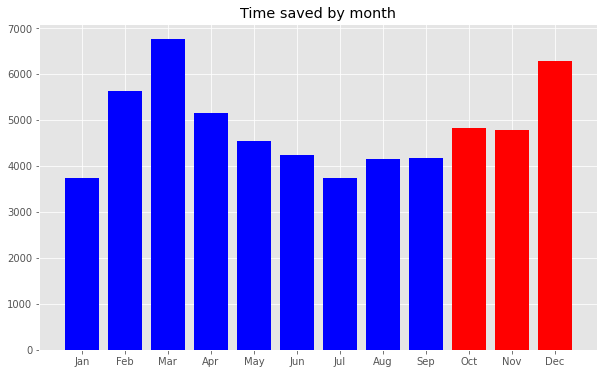

In [19]:
months = [m.month_name()[:3] for m in time_saved_by_month['month']]
days_saved = [ts.days for ts in time_saved_by_month['time_saved_in_month']]

colors = ['blue']*9 + ['red']*3
plt.bar(range(12), days_saved, color=colors)
plt.title('Time saved by month')
plt.xticks(range(12), months)

plt.savefig('time-saved-by-month.png')

plt.show()

In [20]:
top_10_downloads = pd.read_sql(f"""
    SELECT package, COUNT(*) c
    FROM downloads d
    JOIN files USING (filename)
    JOIN builds USING (build_id)
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY package
    ORDER BY c DESC
    LIMIT 10
""", conn)

top_10_downloads

,package,c
0,requests,230601
1,setuptools,214607
2,charset-normalizer,187981
3,pyyaml,187863
4,websocket-client,180099
5,octoprint-firmwarecheck,151629
6,jinja2,150724
7,wheel,139357
8,numpy,135584
9,pigpio-dht,134810


In [21]:
print("<ol>")
for i, row in top_10_downloads.iterrows():
    print(f"<li><strong><a href='https://www.piwheels.org/project/{row['package']}'>{row['package']}</a></strong> ({row['c']:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/requests'>requests</a></strong> (230,601)</li>
<li><strong><a href='https://www.piwheels.org/project/setuptools'>setuptools</a></strong> (214,607)</li>
<li><strong><a href='https://www.piwheels.org/project/charset-normalizer'>charset-normalizer</a></strong> (187,981)</li>
<li><strong><a href='https://www.piwheels.org/project/pyyaml'>pyyaml</a></strong> (187,863)</li>
<li><strong><a href='https://www.piwheels.org/project/websocket-client'>websocket-client</a></strong> (180,099)</li>
<li><strong><a href='https://www.piwheels.org/project/octoprint-firmwarecheck'>octoprint-firmwarecheck</a></strong> (151,629)</li>
<li><strong><a href='https://www.piwheels.org/project/jinja2'>jinja2</a></strong> (150,724)</li>
<li><strong><a href='https://www.piwheels.org/project/wheel'>wheel</a></strong> (139,357)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (135,584)</li>
<li><strong><a href='https://www.piw

In [22]:
top_10_searches = pd.read_sql(f"""
    SELECT package, COUNT(*) c
    FROM searches
    WHERE accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    GROUP BY package
    ORDER BY c desc
    LIMIT 10
""", conn)

top_10_searches

,package,c
0,pip,4755985
1,wheel,3410977
2,setuptools,1717821
3,future,946503
4,pyngrok,835140
5,youtube-dl,678269
6,requests,631481
7,six,527637
8,pyyaml,525629
9,urllib3,512396


In [23]:
print("<ol>")
for pkg, c in top_10_searches.values:
    print(f"<li><strong><a href='https://www.piwheels.org/project/{pkg}'>{pkg}</a></strong> ({c:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/pip'>pip</a></strong> (4,755,985)</li>
<li><strong><a href='https://www.piwheels.org/project/wheel'>wheel</a></strong> (3,410,977)</li>
<li><strong><a href='https://www.piwheels.org/project/setuptools'>setuptools</a></strong> (1,717,821)</li>
<li><strong><a href='https://www.piwheels.org/project/future'>future</a></strong> (946,503)</li>
<li><strong><a href='https://www.piwheels.org/project/pyngrok'>pyngrok</a></strong> (835,140)</li>
<li><strong><a href='https://www.piwheels.org/project/youtube-dl'>youtube-dl</a></strong> (678,269)</li>
<li><strong><a href='https://www.piwheels.org/project/requests'>requests</a></strong> (631,481)</li>
<li><strong><a href='https://www.piwheels.org/project/six'>six</a></strong> (527,637)</li>
<li><strong><a href='https://www.piwheels.org/project/pyyaml'>pyyaml</a></strong> (525,629)</li>
<li><strong><a href='https://www.piwheels.org/project/urllib3'>urllib3</a></strong> (512,396)</li>
</ol>


In [24]:
top_10_project_pages = pd.read_sql(f"""
    SELECT package, COUNT(*) c
    FROM project_page_hits
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY package
    ORDER BY c desc
    LIMIT 10
""", conn)

top_10_project_pages

,package,c
0,opencv-python,2354
1,opencv-contrib-python,1876
2,numpy,1217
3,tensorflow,729
4,scipy,662
5,cryptography,616
6,pandas,516
7,pillow,438
8,grpcio,399
9,pyyaml,362


In [25]:
print("<ol>")
for pkg, c in top_10_project_pages.values:
    print(f"<li><strong><a href='https://www.piwheels.org/project/{pkg}'>{pkg}</a></strong> ({c:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/opencv-python'>opencv-python</a></strong> (2,354)</li>
<li><strong><a href='https://www.piwheels.org/project/opencv-contrib-python'>opencv-contrib-python</a></strong> (1,876)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (1,217)</li>
<li><strong><a href='https://www.piwheels.org/project/tensorflow'>tensorflow</a></strong> (729)</li>
<li><strong><a href='https://www.piwheels.org/project/scipy'>scipy</a></strong> (662)</li>
<li><strong><a href='https://www.piwheels.org/project/cryptography'>cryptography</a></strong> (616)</li>
<li><strong><a href='https://www.piwheels.org/project/pandas'>pandas</a></strong> (516)</li>
<li><strong><a href='https://www.piwheels.org/project/pillow'>pillow</a></strong> (438)</li>
<li><strong><a href='https://www.piwheels.org/project/grpcio'>grpcio</a></strong> (399)</li>
<li><strong><a href='https://www.piwheels.org/project/pyyaml'>pyyaml</a></strong> (362)</li>

In [26]:
top_10_project_json = pd.read_sql(f"""
    SELECT package, count(*) c
    FROM project_json_downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY package
    ORDER BY c desc
    LIMIT 10
""", conn)

top_10_project_json

,package,c
0,awscrt,21132
1,numpy,157
2,opencv-contrib-python,131
3,pyzmq,113
4,opencv-python,101
5,protobuf,88
6,scipy,77
7,obs-streamdeck-controls,72
8,pname,69
9,keras-models,66


In [27]:
print("<ol>")
for pkg, c in top_10_project_json.values:
    print(f"<li><strong><a href='https://www.piwheels.org/project/{pkg}'>{pkg}</a></strong> ({c:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/awscrt'>awscrt</a></strong> (21,132)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (157)</li>
<li><strong><a href='https://www.piwheels.org/project/opencv-contrib-python'>opencv-contrib-python</a></strong> (131)</li>
<li><strong><a href='https://www.piwheels.org/project/pyzmq'>pyzmq</a></strong> (113)</li>
<li><strong><a href='https://www.piwheels.org/project/opencv-python'>opencv-python</a></strong> (101)</li>
<li><strong><a href='https://www.piwheels.org/project/protobuf'>protobuf</a></strong> (88)</li>
<li><strong><a href='https://www.piwheels.org/project/scipy'>scipy</a></strong> (77)</li>
<li><strong><a href='https://www.piwheels.org/project/obs-streamdeck-controls'>obs-streamdeck-controls</a></strong> (72)</li>
<li><strong><a href='https://www.piwheels.org/project/pname'>pname</a></strong> (69)</li>
<li><strong><a href='https://www.piwheels.org/project/keras-models'>keras-models</a><

In [28]:
pd.read_sql(f"""
    SELECT COUNT(DISTINCT(package)) c
    FROM project_json_downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,c
0,116711


In [29]:
pd.read_sql(f"""
    SELECT user_agent, COUNT(*) c
    FROM project_json_downloads
    WHERE accessed_at::date BETWEEN '{start_date}' and '{end_date}'
    GROUP BY user_agent
    ORDER BY c desc
""", conn)

,user_agent,c
0,mozilla,271487
1,python-urllib,21630
2,ccbot,956
3,"""mozilla",110
4,clark-crawler2,25
5,python-requests,17
6,wordpress,5
7,inetdex bot,4
8,elisabot,4
9,ahc,4


In [30]:
os_usage = pd.read_sql(f"""
    SELECT os_name, COUNT(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    GROUP BY os_name
    ORDER BY c desc
""", conn)

os_usage

,os_name,c
0,Linux,58827696
1,Windows,24566
2,Darwin,15289
3,FreeBSD,2914
4,Open Surface RT - Linux,706
5,CYGWIN_NT-6.1-7601-WOW64,15
6,CYGWIN_NT-10.0-19042,3


In [31]:
linux_usage_pc = 100 * (os_usage.values[0][1] / searches)
print(f'{linux_usage_pc:2.2f}% linux')

99.93% linux


In [32]:
distro_usage = pd.read_sql(f"""
    SELECT distro_name, COUNT(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    AND os_name = 'Linux'
    GROUP BY distro_name
    ORDER BY c desc
    LIMIT 5
""", conn)

distro_usage

,distro_name,c
0,Raspbian GNU/Linux,52404501
1,Debian GNU/Linux,5727911
2,Ubuntu,415840
3,OSMC,121189
4,Alpine Linux,94320


In [33]:
debian_usage = pd.read_sql(f"""
    SELECT count(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    AND os_name = 'Linux'
    AND distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    ORDER BY c desc
    LIMIT 5
""", conn)

debian_usage

,c
0,58132412


In [34]:
debian_usage_pc = 100 * (debian_usage.c[0] / searches)
print(f'{debian_usage_pc:2.2f}% debian')

98.75% debian


In [35]:
ubuntu_usage = pd.read_sql(f"""
    SELECT count(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    AND os_name = 'Linux'
    AND distro_name = 'Ubuntu'
    ORDER BY c desc
    LIMIT 5
""", conn)

ubuntu_usage_pc = 100 * (ubuntu_usage.c[0] / searches)
print(f'{ubuntu_usage_pc:2.2f}% ubuntu')

0.71% ubuntu


In [36]:
debian = debian_usage.values[0][0]
others = searches - debian

distro_usage = {
    'Debian / Raspberry Pi OS': debian,
    'Others': others,
}

distro_usage

{'Debian / Raspberry Pi OS': 58132412, 'Others': 738770}

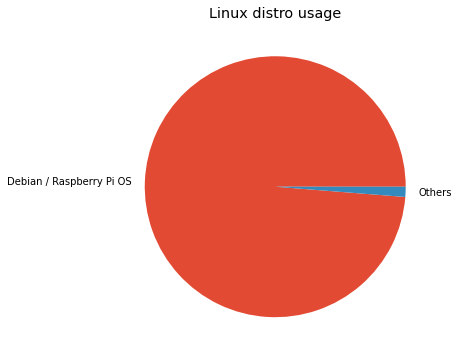

In [37]:
plt.pie(distro_usage.values(), labels=distro_usage.keys())
plt.title('Linux distro usage')

plt.savefig('distro-usage.png')

plt.show()

In [38]:
distro_versions = pd.read_sql(f"""
    SELECT distro_version, count(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    AND os_name = 'Linux'
    AND distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    AND distro_version in ('8', '9', '10', '11')
    GROUP BY distro_version
    ORDER BY c desc
""", conn)

distro_versions

,distro_version,c
0,10,39513587
1,11,14652519
2,9,3907972
3,8,851


In [39]:
total = sum(distro_versions.c)

for v in distro_versions.values:
    print(v[0], f'{(100 * v[1] / total):.1f}%')

10 68.0%
11 25.2%
9 6.7%
8 0.0%


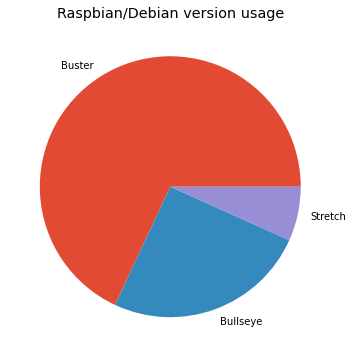

In [40]:
version_names = {'11': 'Bullseye', '10': 'Buster', '9': 'Stretch', '8': 'Jessie'}
plt.pie(distro_versions.c[:3], labels=[version_names[v] for v in distro_versions.distro_version][:3])
plt.title('Raspbian/Debian version usage')

plt.savefig('debian-usage.png')

plt.show()

In [41]:
arch = pd.read_sql(f"""
    SELECT arch, COUNT(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    GROUP BY arch
    ORDER BY c DESC
""", conn)

arch

,arch,c
0,armv7l,50854344
1,x86_64,3265878
2,aarch64,2701818
3,armv6l,1945464
4,i686,43467
5,armv8l,29856
6,AMD64,24566
7,amd64,2914
8,arm64,2857
9,s390x,14


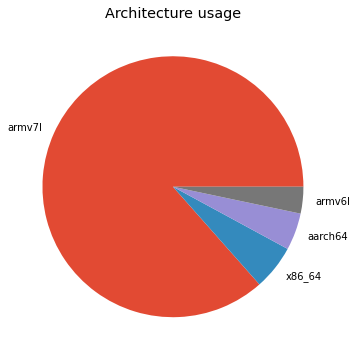

In [42]:
plt.pie(arch.c[:4], labels=arch.arch[:4])
plt.title('Architecture usage')

plt.savefig('arch.png')

plt.show()

In [61]:
for v in arch.values[:4]:
    print(v[0], f'{(100 * v[1] / total):.1f}%') 

armv7l 89.6%
x86_64 5.8%
aarch64 4.8%
armv6l 3.4%


In [43]:
arm_arch = pd.read_sql(f"""
    SELECT arch, COUNT(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    AND os_name = 'Linux'
    AND distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    AND arch in ('armv6l', 'armv7l', 'aarch64')
    GROUP BY arch
    ORDER BY c DESC
""", conn)

total = sum(arm_arch.c)

for v in arm_arch.values:
    print(v[0], f'{(100 * v[1] / total):.1f}%') 

armv7l 91.9%
aarch64 4.6%
armv6l 3.5%


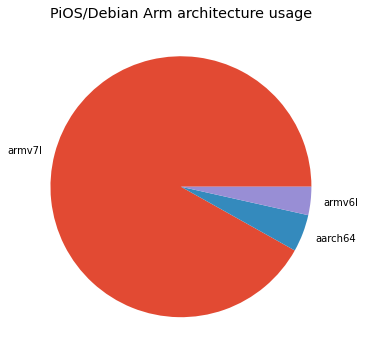

In [44]:
plt.pie(arm_arch.c, labels=arm_arch.arch)
plt.title('PiOS/Debian Arm architecture usage')

plt.savefig('debian-arch.png')

plt.show()

In [45]:
py_vers = pd.read_sql(f"""
    SELECT SUBSTRING(py_version from 1 for 3) pyver, COUNT(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    AND os_name = 'Linux'
    AND distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    AND arch in ('armv6l', 'armv7l', 'aarch64')
    AND py_name = 'CPython'
    GROUP BY pyver
    ORDER BY c desc
    LIMIT 6
""", conn)

py_vers

,pyver,c
0,3.7,29706026
1,3.9,13235793
2,2.7,7073097
3,3.8,2620084
4,3.5,2017367
5,3.6,325941


In [62]:
py_vers = pd.read_sql(f"""
    SELECT py_version, COUNT(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    AND os_name = 'Linux'
    AND distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    AND arch in ('armv6l', 'armv7l', 'aarch64')
    AND py_name = 'CPython'
    GROUP BY py_version
""", conn)

py_vers

,py_version,c
0,2.7.10,560
1,2.7.13,1348576
2,2.7.14,115
3,2.7.15,1247
4,2.7.15+,2
...,...,...
122,3.9.7,271731
123,3.9.7+,26
124,3.9.8,63481
125,3.9.8+,135


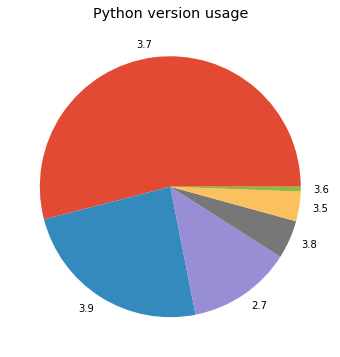

In [46]:
plt.pie(py_vers.c, labels=py_vers.pyver)
plt.title('Python version usage')

plt.savefig('py-vers.png')

plt.show()

In [47]:
total = sum(row[1] for row in py_vers.values)

for ver, c in py_vers.values:
    print(ver, f'{100 * (c / total):.2f}%')

3.7 54.03%
3.9 24.07%
2.7 12.87%
3.8 4.77%
3.5 3.67%
3.6 0.59%


In [48]:
pip_versions = pd.read_sql(f"""
    SELECT installer_version, COUNT(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    AND installer_name = 'pip'
    AND installer_version is not null
    GROUP BY installer_version
    ORDER BY c DESC
""", conn)

pip_versions[:10]

,installer_version,c
0,21.3.1,23942426
1,18.1,10746363
2,21.2.4,5398419
3,20.3.4,3965603
4,21.3,2445858
5,19.0.1,2201286
6,20.3.3,2115040
7,9.0.1,1394927
8,20.2.4,1038391
9,19.3.1,1027908


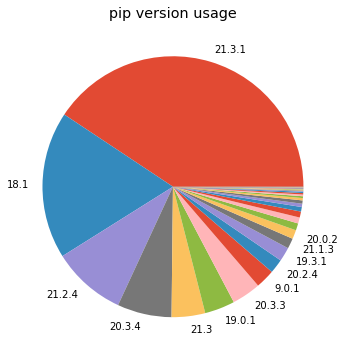

In [49]:
total = sum(v[1] for v in pip_versions.values)
labels = [v[0] if v[1] / total > 0.01 else '' for v in pip_versions.values]

plt.pie(pip_versions.c, labels=labels)
plt.title('pip version usage')

plt.savefig('pip-vers.png')

plt.show()

In [50]:
setuptools_versions = pd.read_sql(f"""
    SELECT setuptools_version, COUNT(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    AND installer_name = 'pip'
    AND setuptools_version is not null
    GROUP BY setuptools_version
    ORDER BY c DESC
""", conn)

setuptools_versions[:10]

,setuptools_version,c
0,40.8.0,22903281
1,52.0.0,10143091
2,40.7.1,2227188
3,44.1.1,2039706
4,57.5.0,2018108
5,51.1.2,1965447
6,58.2.0,1476916
7,41.5.1,1014471
8,58.3.0,1002916
9,57.4.0,986075


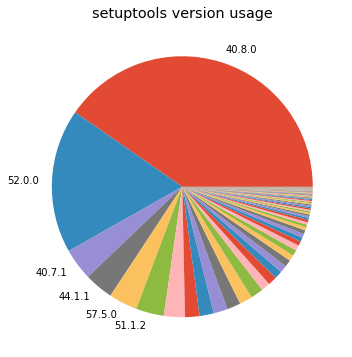

In [51]:
total = sum(v[1] for v in setuptools_versions.values)
labels = [v[0] if v[1] / total > 0.03 else '' for v in setuptools_versions.values]

plt.pie(setuptools_versions.c, labels=labels)
plt.title('setuptools version usage')

plt.savefig('setuptools-vers.png')

plt.show()

In [52]:
import csv
from glob import glob
from collections import defaultdict

In [53]:
ONE_TB = 1e12
months = (
    '202007', '202008', '202009', '202010', '202011', '202012',
    '202101', '202102', '202103', '202104', '202105', '202106', '202107', '202108', '202109', '202110', '202111', '202112'
)

bandwidth = {}
bandwidth_totals = defaultdict(int)
for month in months:
    bandwidth[month] = defaultdict(int)
    files = glob('/home/ben/piwheels-logs/' + month + '/*-sizes.csv')
    for file in files:
        with open(file) as f:
            r = csv.reader(f)
            for log_type, count in r:
                bandwidth[month][log_type] += int(count)
                bandwidth_totals[month] += int(count) / ONE_TB

In [54]:
for month, data in bandwidth_totals.items():
    print(month, f'{data:.2f} TB')

202007 3.92 TB
202008 6.38 TB
202009 6.27 TB
202010 6.58 TB
202011 4.43 TB
202012 3.32 TB
202101 3.79 TB
202102 5.87 TB
202103 7.07 TB
202104 5.35 TB
202105 4.82 TB
202106 4.72 TB
202107 4.02 TB
202108 4.29 TB
202109 3.91 TB
202110 5.19 TB
202111 5.54 TB
202112 5.10 TB


In [55]:
m1, m2, m3 = months[-3:]

bandwidth_in_period = {
    'pip downloads': bandwidth[m1]['LOGDOWNLOAD'] + bandwidth[m2]['LOGDOWNLOAD'] + bandwidth[m3]['LOGDOWNLOAD'],
    'Misc': bandwidth[m1]['OTHER'] + bandwidth[m2]['OTHER'] + bandwidth[m3]['OTHER'],
    'Searches': bandwidth[m1]['LOGSEARCH'] + bandwidth[m2]['LOGSEARCH'] + bandwidth[m3]['LOGSEARCH'],
    '': (
        bandwidth[m1]['LOGPROJECT'] + bandwidth[m2]['LOGPROJECT'] + bandwidth[m3]['LOGPROJECT'] +
        bandwidth[m1]['LOGJSON'] + bandwidth[m2]['LOGJSON'] + bandwidth[m3]['LOGJSON'] +
        bandwidth[m1]['LOGPAGE'] + bandwidth[m2]['LOGPAGE'] + bandwidth[m3]['LOGPAGE']
    ),
}

bandwidth_in_period

{'pip downloads': 12651816367109,
 'Misc': 2770343186807,
 'Searches': 393180853502,
 '': 14604015185}

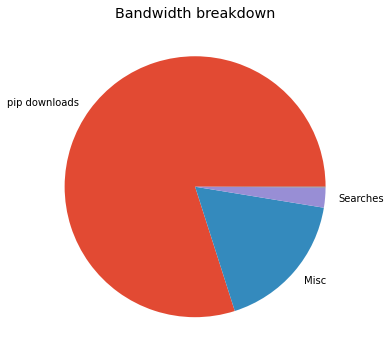

In [56]:
plt.pie(bandwidth_in_period.values(), labels=bandwidth_in_period.keys())
plt.title('Bandwidth breakdown')

plt.savefig('bandwidth.png')

plt.show()

In [57]:
for k, v in bandwidth_in_period.items():
    pc = 100 * (v / sum(bandwidth_in_period.values()))
    print(k, f'{pc:.2f}%')

pip downloads 79.92%
Misc 17.50%
Searches 2.48%
 0.09%


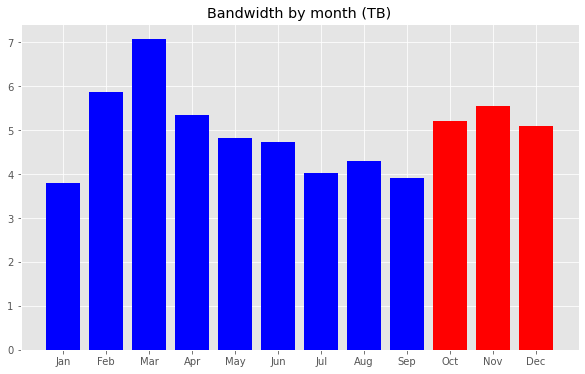

In [59]:
bandwidth_by_month = {
    'Jan': bandwidth_totals['202101'],
    'Feb': bandwidth_totals['202102'],
    'Mar': bandwidth_totals['202103'],
    'Apr': bandwidth_totals['202104'],
    'May': bandwidth_totals['202105'],
    'Jun': bandwidth_totals['202106'],
    'Jul': bandwidth_totals['202107'],
    'Aug': bandwidth_totals['202108'],
    'Sep': bandwidth_totals['202109'],
    'Oct': bandwidth_totals['202110'],
    'Nov': bandwidth_totals['202111'],
    'Dec': bandwidth_totals['202112'],
}

colors = ['blue']*9 + ['red']*3
plt.bar(range(len(bandwidth_by_month)), bandwidth_by_month.values(), color=colors)
plt.title('Bandwidth by month (TB)')
plt.xticks(range(len(bandwidth_by_month)), list(bandwidth_by_month.keys()))

plt.savefig('bandwidth-by-month.png')

plt.show()